# Diplomski rad 06
28\. 6. 2017.

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import graphviz as gv

import networkx as nx
import pydot
import os
from utility.log_progress import log_progress
from importlib import reload
import utility.functions
reload(utility.functions)
from utility.functions import *
from collections import Counter

matplotlib.rcParams['figure.figsize'] = (12, 8)

## S&P full

In [164]:
spfull = np.load('data/sp_stock_prices.npy')
spstocks = np.load('data/sp_stocks.npy')
spdates = np.load('data/sp_price_dates.npy')
spchangedates = np.load('data/sp_change_dates.npy')
spchangelist = np.load('data/sp_change_list.npy')

days, N = spfull.shape
P = N * (N - 1) // 2
spfull_log = np.log(spfull)

T = 60

In [194]:
spchangesets = [set(s) for s in [[p for p in r if p != ''] for r in spchangelist.T]]
split_points, = np.where(np.vectorize(lambda s: s in spchangedates)(spdates))
# split_points je za jedan kraći od changesets-a (na kraju)
# prvi split point je 54, a period T je 60, da bude lakše stavit ćemo da je prvi split point 60
if split_points[0] < T:
    split_points[0] = T

print(split_points)

[  60  119  189  254  314  384  449  514  579  644  709  774  839  904  969
 1034 1099 1164 1229 1294 1359 1424 1489 1554 1619 1689 1754 1819 1884 1949
 2014 2079 2144 2209 2274 2339 2404 2469 2534 2599 2664 2729 2794 2859 2924
 2989 3059 3124 3184 3254 3319 3384 3449 3514 3579 3644 3709 3774 3839 3904
 3969 4034 4099 4164 4229 4294 4359 4424 4489 4554 4624 4689 4753 4819 4884
 4949 5014 5079 5144 5209 5274 5339 5404 5469 5534 5599 5664 5729 5794 5859
 5929 5994 6054 6124 6189 6254 6319 6384 6449 6514 6579 6644 6709 6774]


In [219]:
for i in range(len(split_points)):
    stock_set = spchangesets[i]
    start_date = spdates[i]
    end_date = spdates[i + 1] if i < len(split_points) else spdates[-2]
    start_point = split_points[i]
    end_point = split_points[i + 1] if i < len(split_points) - 1 else len(spdates) - 1
    stock_prices = spfull_log[start_point:end_point, np.where(np.vectorize(lambda s: s in stock_set)(spstocks))[0]]
    

In [225]:
np.sum(np.isnan(spfull_log))

1346966

## SPDR

In [230]:
spdr = np.load('data/spdr_prices.npy')
days, N = spdr.shape
P = N * (N - 1) // 2
spdr_log = np.log(spdr)
spdr_log_diffs = calculate_pairwise_diffs(spdr_log)

In [264]:
T = 60
p = None
d = 3.75
method = 'thresh-devs'
spdr_log_diff_means, spdr_log_diff_vars = rolling_mean_variance(spdr_log_diffs, T)
ts, profits, pairs, weights = statistical_arbitrage(spdr_log_diffs, spdr_log_diff_means, spdr_log_diff_vars, p=p, d=d,
                                                    method=method, return_pairs=True, return_weights=True)

In [265]:
ppairs = partition_as(ts, pairs, weights)
profit = []
shares = []
ts_plot = []
exp_tops = []
exp_bottoms = []
a = 0.5
b = 2
for t, ppair, weight in log_progress(list(ppairs)):
    preferences, c = calculate_preference_flow(ppair, weights=weight, scale=False, return_consistency=True)
    c = a + (1 - a) * c ** b
    # c = 0.5 + np.sqrt(c) / 2
    # c = 0.8 + c * 0.2
    m = np.max(np.abs(list(preferences.values())))
    # n = np.min(list(preferences.values()))
    tops = np.array([k for k, v in preferences.items() if v >= m * c])
    # tops = np.array([])
    bottoms = np.array([k for k, v in preferences.items() if -m * c >= v])
    p = []
    if len(tops) != 0:
        ttops = np.array([t] * len(tops))
        p.extend(trade_singles(spdr_log, ttops, tops, inv=False))
        shares.extend(tops)
        ts_plot.extend(ttops)
    if len(bottoms) != 0:
        tbottoms = np.array([t] * len(bottoms))
        p.extend(trade_singles(spdr_log, tbottoms, bottoms, inv=True))
        shares.extend(bottoms)
        ts_plot.extend(tbottoms)
    if len(tops) == 0:
        ts_plot.append(t)
        profit.append(0)
    exp_tops += [set(tops)]
    exp_bottoms += [set(bottoms)]
    profit.extend([p_ / len(p) for p_ in p])
    
shares = np.array(shares)
ts_plot = np.array(ts_plot)
profit = np.array(profit)

T: 60
d: 3.75
a: 0.5, b: 2
Avg (year): 0.54878
Stddev (year): 0.37273
Sharpe ratio (year): 1.47234
Profit:
  positive only: 1.23769
  negative only: -0.71508
  total: 0.52261
  positive to negative ratio: 1.73085
Average accuracy: 0.54717
Average turnovers (range [0, 2]):
  top: 1.22414
  bottom: 1.10345
  total: 1.16379
Total turnovers:
  top: 142.00000
  bottom: 128.00000
  total: 270.00000
Actual profit, if transaction cost were 0.1%: 0.25261


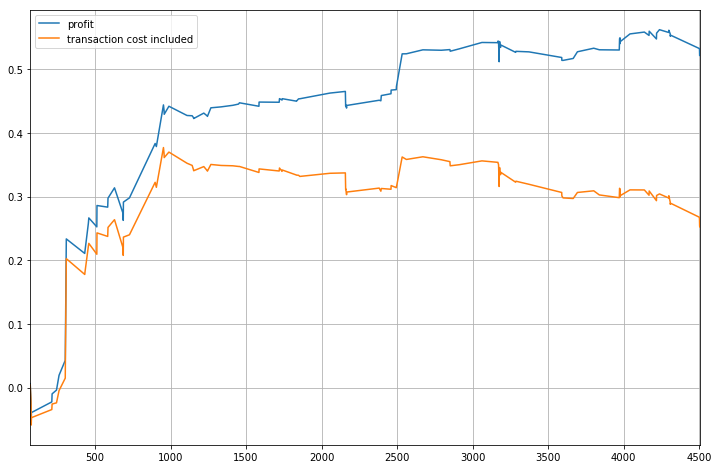

In [266]:
turnover_top = turnover_ratio(exp_tops)
turnover_bottom = turnover_ratio(exp_bottoms)

ts1, profit1 = join_ts_profit(ts_plot, profit)

plt.figure()
plt.plot(ts1, np.cumsum(profit1))
plt.plot(ts1, np.cumsum(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3))
plt.legend(['profit', 'transaction cost included'], loc='best')
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid()

avg = np.mean(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * 252
std = np.std(profit1 - np.sum(np.vstack([turnover_top, turnover_bottom]), axis=0) * 1e-3) * np.sqrt(252)
sharpe = avg / std

total_positive = np.sum(profit[np.greater(profit, 0.0)])
total_negative = np.sum(profit[np.less_equal(profit, 0.0)])


print('T: {}'.format(T))
print('d: {}'.format(d))
print('a: {}, b: {}'.format(a, b))
print('Avg (year): {:.5f}'.format(avg))
print('Stddev (year): {:.5f}'.format(std))
print('Sharpe ratio (year): {:.5f}'.format(sharpe))
print('Profit:')
print('  positive only: {:.5f}'.format(total_positive))
print('  negative only: {:.5f}'.format(total_negative))
print('  total: {:.5f}'.format(total_positive + total_negative))
print('  positive to negative ratio: {:.5f}'.format(-total_positive / total_negative))
print('Average accuracy: {:.5f}'.format(np.count_nonzero(np.greater(profit, 0.0)) / len(profit)))
print('Average turnovers (range [0, 2]):')
print('  top: {:.5f}'.format(np.mean(turnover_top)))
print('  bottom: {:.5f}'.format(np.mean(turnover_bottom)))
print('  total: {:.5f}'.format(np.mean(np.hstack([turnover_bottom, turnover_top]))))
print('Total turnovers:')
print('  top: {:.5f}'.format(np.sum(turnover_top)))
print('  bottom: {:.5f}'.format(np.sum(turnover_bottom)))
print('  total: {:.5f}'.format(np.sum(np.hstack([turnover_bottom, turnover_top]))))
print('Actual profit, if transaction cost were 0.1%: {:.5f}'.format(np.sum(profit) - np.sum(np.hstack([turnover_bottom, turnover_top])) * 1e-3))
